In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import numpy as np
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Гиперпараметры (фиксированные)
batch_size = 64
epochs = 10
lr = 1e-3
weight_decay = 1e-7 # небольшой штраф

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [2]:
# оценка энтропии через Гауссово распределение (logdet(covariance))
def myent(h):
    return torch.logdet(torch.cov(h) + 1e-4 * torch.eye(h.shape[0]).to(h.device))/h.shape[0]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, k, tau=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.k = k
        self.tau = tau

        self.mask_logits = nn.Parameter(torch.randn(output_dim, input_dim))

        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))

    def sample_mask(self):
        gumbel_noise = -torch.empty_like(self.mask_logits).exponential_().log()
        if self.tau > 0:
            y = (self.mask_logits + gumbel_noise) / self.tau
        else:
            y = self.mask_logits
        soft_mask = F.softmax(y, dim=-1)  # shape: (output_dim, input_dim)

        topk_values, topk_indices = torch.topk(soft_mask, self.k, dim=-1)

        hard_mask = torch.zeros_like(soft_mask)
        hard_mask.scatter_(1, topk_indices, 1.0)

        mask = (hard_mask - soft_mask).detach() + soft_mask
        return mask

    def forward(self, x):
        mask = self.sample_mask()  # shape: (output_dim, input_dim)
        masked_weight = self.weight * mask
        return F.linear(x, masked_weight, self.bias)

In [ ]:
def run_det(mi_coef, k, conv_like = True):
  
    hidden = 28*28 
    enc = torch.nn.Sequential(SparseLinearLayer(28*28, hidden, k**2)).to(device)
    if conv_like: # хардкодим маски в стиле сверток
        for i in range(28*28):
            ij = np.unravel_index(i, (28, 28))
            enc[0].mask_logits.data[i]*=0
            enc[0].mask_logits.data[i]-=100
            for j1 in range(-(k//2), k//2+1):
                for j2 in range(-(k//2), k//2+1):
                    ij2 = ij[0]+j1, ij[1]+j2
                    if ij2[0]>=0 and ij2[0]<28 and ij2[1]>=0 and ij2[1]<28:
                        i2 = ij2[0]*28+ij2[1]
                        enc[0].mask_logits.data[i, i2] += 100
    else: # делаем их рандомными
        pixels = list(range(28*28))
        for i in range(28*28):
            np.random.shuffle(pixels)
            for i2 in pixels[:k*k]:
                enc[0].mask_logits.data[i, i2] += 100

    enc[0].mask_logits.requires_grad_(False)
    enc[0].tau = 0.0 # нам не нужна стохастика
    dec = torch.nn.Linear(hidden, 28*28).to(device)
    head = torch.nn.Linear(hidden, 10).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(list(enc.parameters())+ list(dec.parameters())+list(head.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Обучение
    for epoch in range(epochs):
        tq = tqdm.tqdm(train_loader)
        for b_id, (x, y) in enumerate(tq):
            x, y = x.to(device), y.to(device)
            x = x.flatten(1)
            
            h = enc(x)  
            loss = myent(h)*mi_coef
            h = torch.sigmoid(h)
            
            
            outputs = dec(h)
            loss += criterion(head(h), y)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.set_description(str(loss.item()))

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    mi_ = 0.0
    rec = 0.0
    # Тестирование
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            h = enc(images.flatten(1))  
            mi_ += myent(h)
            h = torch.sigmoid(h)
            
            
            outputs =  head(h)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            outputs = dec(h)

            rec += ((outputs-images.flatten(1))**2).mean().item()

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")
    print ('rec', rec/len(train_loader))
    print ('mi:', mi_.item())
    return enc, 100 * correct / total, rec/len(train_loader), mi_.item()


In [8]:
accs = []
recs = []
mis = []
for f in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.5, 5.0]:
    enc, acc, rec, mi = run_det(f, 3)
    accs.append(acc)
    recs.append(rec)
    mis.append(mi)

0.7288621664047241: 100%|████████████████████| 938/938 [00:06<00:00, 138.14it/s]


Epoch [1/10], Loss: 0.7289


0.5718590021133423: 100%|████████████████████| 938/938 [00:06<00:00, 139.07it/s]


Epoch [2/10], Loss: 0.5719


0.22484879195690155: 100%|███████████████████| 938/938 [00:06<00:00, 139.92it/s]


Epoch [3/10], Loss: 0.2248


0.1876804232597351: 100%|████████████████████| 938/938 [00:06<00:00, 140.68it/s]


Epoch [4/10], Loss: 0.1877


0.12551330029964447: 100%|███████████████████| 938/938 [00:06<00:00, 138.45it/s]


Epoch [5/10], Loss: 0.1255


0.28296589851379395: 100%|███████████████████| 938/938 [00:06<00:00, 136.12it/s]


Epoch [6/10], Loss: 0.2830


0.03781912475824356: 100%|███████████████████| 938/938 [00:06<00:00, 136.45it/s]


Epoch [7/10], Loss: 0.0378


0.24159188568592072: 100%|███████████████████| 938/938 [00:06<00:00, 137.32it/s]


Epoch [8/10], Loss: 0.2416


0.1211969330906868: 100%|████████████████████| 938/938 [00:06<00:00, 136.14it/s]


Epoch [9/10], Loss: 0.1212


0.07750646024942398: 100%|███████████████████| 938/938 [00:06<00:00, 137.83it/s]


Epoch [10/10], Loss: 0.0775
Accuracy on test set: 95.33%
rec 0.1865923856494269
mi: 218.07846069335938


0.48967576026916504: 100%|███████████████████| 938/938 [00:06<00:00, 146.85it/s]


Epoch [1/10], Loss: 0.4897


0.28758376836776733: 100%|███████████████████| 938/938 [00:06<00:00, 146.78it/s]


Epoch [2/10], Loss: 0.2876


0.44870689511299133: 100%|███████████████████| 938/938 [00:06<00:00, 147.46it/s]


Epoch [3/10], Loss: 0.4487


0.3409302830696106: 100%|████████████████████| 938/938 [00:06<00:00, 147.39it/s]


Epoch [4/10], Loss: 0.3409


0.22581303119659424: 100%|███████████████████| 938/938 [00:06<00:00, 148.66it/s]


Epoch [5/10], Loss: 0.2258


0.18402333557605743: 100%|███████████████████| 938/938 [00:06<00:00, 148.91it/s]


Epoch [6/10], Loss: 0.1840


0.1416931003332138: 100%|████████████████████| 938/938 [00:06<00:00, 149.58it/s]


Epoch [7/10], Loss: 0.1417


0.10036854445934296: 100%|███████████████████| 938/938 [00:06<00:00, 147.33it/s]


Epoch [8/10], Loss: 0.1004


0.07862825691699982: 100%|███████████████████| 938/938 [00:06<00:00, 148.43it/s]


Epoch [9/10], Loss: 0.0786


0.17696714401245117: 100%|███████████████████| 938/938 [00:06<00:00, 147.84it/s]


Epoch [10/10], Loss: 0.1770
Accuracy on test set: 94.07%
rec 0.17937597854813533
mi: -178.8216094970703


0.3936278820037842: 100%|████████████████████| 938/938 [00:06<00:00, 149.90it/s]


Epoch [1/10], Loss: 0.3936


0.42723461985588074: 100%|███████████████████| 938/938 [00:06<00:00, 150.73it/s]


Epoch [2/10], Loss: 0.4272


0.18014240264892578: 100%|███████████████████| 938/938 [00:06<00:00, 147.96it/s]


Epoch [3/10], Loss: 0.1801


0.12733794748783112: 100%|███████████████████| 938/938 [00:06<00:00, 148.41it/s]


Epoch [4/10], Loss: 0.1273


-0.15362000465393066: 100%|██████████████████| 938/938 [00:06<00:00, 146.25it/s]


Epoch [5/10], Loss: -0.1536


-0.27637872099876404: 100%|██████████████████| 938/938 [00:06<00:00, 147.50it/s]


Epoch [6/10], Loss: -0.2764


-0.12202203273773193: 100%|██████████████████| 938/938 [00:06<00:00, 150.32it/s]


Epoch [7/10], Loss: -0.1220


-0.281260222196579: 100%|████████████████████| 938/938 [00:06<00:00, 147.57it/s]


Epoch [8/10], Loss: -0.2813


-0.3617958128452301: 100%|███████████████████| 938/938 [00:06<00:00, 141.78it/s]


Epoch [9/10], Loss: -0.3618


-0.5312367081642151: 100%|███████████████████| 938/938 [00:06<00:00, 150.29it/s]


Epoch [10/10], Loss: -0.5312
Accuracy on test set: 89.91%
rec 0.18236150861040615
mi: -697.499755859375


0.6329644918441772: 100%|████████████████████| 938/938 [00:06<00:00, 151.56it/s]


Epoch [1/10], Loss: 0.6330


0.018233701586723328: 100%|██████████████████| 938/938 [00:06<00:00, 152.74it/s]


Epoch [2/10], Loss: 0.0182


-0.2138955146074295: 100%|███████████████████| 938/938 [00:06<00:00, 153.47it/s]


Epoch [3/10], Loss: -0.2139


-0.2708251476287842: 100%|███████████████████| 938/938 [00:06<00:00, 154.06it/s]


Epoch [4/10], Loss: -0.2708


-0.40304797887802124: 100%|██████████████████| 938/938 [00:06<00:00, 154.14it/s]


Epoch [5/10], Loss: -0.4030


-0.7597455978393555: 100%|███████████████████| 938/938 [00:06<00:00, 154.21it/s]


Epoch [6/10], Loss: -0.7597


-0.47325557470321655: 100%|██████████████████| 938/938 [00:06<00:00, 153.72it/s]


Epoch [7/10], Loss: -0.4733


-0.7532114386558533: 100%|███████████████████| 938/938 [00:06<00:00, 152.31it/s]


Epoch [8/10], Loss: -0.7532


-0.9645987749099731: 100%|███████████████████| 938/938 [00:06<00:00, 152.73it/s]


Epoch [9/10], Loss: -0.9646


-0.9383439421653748: 100%|███████████████████| 938/938 [00:06<00:00, 154.33it/s]


Epoch [10/10], Loss: -0.9383
Accuracy on test set: 83.80%
rec 0.18136372367964623
mi: -1082.36474609375


0.17990612983703613: 100%|███████████████████| 938/938 [00:06<00:00, 154.07it/s]


Epoch [1/10], Loss: 0.1799


-0.20540481805801392: 100%|██████████████████| 938/938 [00:06<00:00, 154.97it/s]


Epoch [2/10], Loss: -0.2054


-0.29556626081466675: 100%|██████████████████| 938/938 [00:06<00:00, 154.09it/s]


Epoch [3/10], Loss: -0.2956


-0.9521163702011108: 100%|███████████████████| 938/938 [00:06<00:00, 153.51it/s]


Epoch [4/10], Loss: -0.9521


-1.377916932106018: 100%|████████████████████| 938/938 [00:06<00:00, 150.20it/s]


Epoch [5/10], Loss: -1.3779


-1.6519267559051514: 100%|███████████████████| 938/938 [00:06<00:00, 153.80it/s]


Epoch [6/10], Loss: -1.6519


-1.8448686599731445: 100%|███████████████████| 938/938 [00:06<00:00, 154.45it/s]


Epoch [7/10], Loss: -1.8449


-1.7705492973327637: 100%|███████████████████| 938/938 [00:06<00:00, 153.01it/s]


Epoch [8/10], Loss: -1.7705


-1.7191354036331177: 100%|███████████████████| 938/938 [00:06<00:00, 152.60it/s]


Epoch [9/10], Loss: -1.7191


-1.6341636180877686: 100%|███████████████████| 938/938 [00:06<00:00, 154.52it/s]


Epoch [10/10], Loss: -1.6342
Accuracy on test set: 83.35%
rec 0.18426868090751583
mi: -1138.093505859375


0.4299789071083069: 100%|████████████████████| 938/938 [00:06<00:00, 152.40it/s]


Epoch [1/10], Loss: 0.4300


-0.4176400601863861: 100%|███████████████████| 938/938 [00:06<00:00, 152.53it/s]


Epoch [2/10], Loss: -0.4176


-0.9660558700561523: 100%|███████████████████| 938/938 [00:06<00:00, 153.36it/s]


Epoch [3/10], Loss: -0.9661


-2.164463520050049: 100%|████████████████████| 938/938 [00:06<00:00, 153.59it/s]


Epoch [4/10], Loss: -2.1645


-2.4190711975097656: 100%|███████████████████| 938/938 [00:06<00:00, 152.85it/s]


Epoch [5/10], Loss: -2.4191


-1.96080482006073: 100%|█████████████████████| 938/938 [00:06<00:00, 152.14it/s]


Epoch [6/10], Loss: -1.9608


-2.1580817699432373: 100%|███████████████████| 938/938 [00:06<00:00, 152.08it/s]


Epoch [7/10], Loss: -2.1581


-1.9144536256790161: 100%|███████████████████| 938/938 [00:06<00:00, 153.66it/s]


Epoch [8/10], Loss: -1.9145


-2.3939504623413086: 100%|███████████████████| 938/938 [00:06<00:00, 153.35it/s]


Epoch [9/10], Loss: -2.3940


-2.4414875507354736: 100%|███████████████████| 938/938 [00:06<00:00, 153.03it/s]


Epoch [10/10], Loss: -2.4415
Accuracy on test set: 79.37%
rec 0.17933857542619522
mi: -1166.2984619140625


0.46604427695274353: 100%|███████████████████| 938/938 [00:06<00:00, 153.57it/s]


Epoch [1/10], Loss: 0.4660


-0.6838963031768799: 100%|███████████████████| 938/938 [00:06<00:00, 154.83it/s]


Epoch [2/10], Loss: -0.6839


-1.5763912200927734: 100%|███████████████████| 938/938 [00:06<00:00, 152.69it/s]


Epoch [3/10], Loss: -1.5764


-2.2082509994506836: 100%|███████████████████| 938/938 [00:06<00:00, 152.81it/s]


Epoch [4/10], Loss: -2.2083


-2.788245439529419: 100%|████████████████████| 938/938 [00:06<00:00, 153.36it/s]


Epoch [5/10], Loss: -2.7882


-3.169363021850586: 100%|████████████████████| 938/938 [00:06<00:00, 153.45it/s]


Epoch [6/10], Loss: -3.1694


-2.91090989112854: 100%|█████████████████████| 938/938 [00:06<00:00, 153.76it/s]


Epoch [7/10], Loss: -2.9109


-2.830984115600586: 100%|████████████████████| 938/938 [00:06<00:00, 155.07it/s]


Epoch [8/10], Loss: -2.8310


-3.5661673545837402: 100%|███████████████████| 938/938 [00:06<00:00, 153.91it/s]


Epoch [9/10], Loss: -3.5662


-3.326840400695801: 100%|████████████████████| 938/938 [00:06<00:00, 153.56it/s]


Epoch [10/10], Loss: -3.3268
Accuracy on test set: 76.44%
rec 0.18509674250189936
mi: -1209.4688720703125


0.25157493352890015: 100%|███████████████████| 938/938 [00:06<00:00, 153.52it/s]


Epoch [1/10], Loss: 0.2516


-1.2402524948120117: 100%|███████████████████| 938/938 [00:06<00:00, 151.99it/s]


Epoch [2/10], Loss: -1.2403


-2.7120025157928467: 100%|███████████████████| 938/938 [00:06<00:00, 151.77it/s]


Epoch [3/10], Loss: -2.7120


-3.4102489948272705: 100%|███████████████████| 938/938 [00:06<00:00, 152.78it/s]


Epoch [4/10], Loss: -3.4102


-3.211864948272705: 100%|████████████████████| 938/938 [00:06<00:00, 152.35it/s]


Epoch [5/10], Loss: -3.2119


-3.6871960163116455: 100%|███████████████████| 938/938 [00:06<00:00, 152.61it/s]


Epoch [6/10], Loss: -3.6872


-3.9043049812316895: 100%|███████████████████| 938/938 [00:06<00:00, 153.67it/s]


Epoch [7/10], Loss: -3.9043


-4.015945911407471: 100%|████████████████████| 938/938 [00:06<00:00, 151.61it/s]


Epoch [8/10], Loss: -4.0159


-3.9952259063720703: 100%|███████████████████| 938/938 [00:06<00:00, 153.44it/s]


Epoch [9/10], Loss: -3.9952


-4.035671234130859: 100%|████████████████████| 938/938 [00:06<00:00, 153.13it/s]


Epoch [10/10], Loss: -4.0357
Accuracy on test set: 77.17%
rec 0.1807718151795076
mi: -1221.818603515625


-0.13625895977020264: 100%|██████████████████| 938/938 [00:06<00:00, 153.43it/s]


Epoch [1/10], Loss: -0.1363


-1.3517175912857056: 100%|███████████████████| 938/938 [00:06<00:00, 154.63it/s]


Epoch [2/10], Loss: -1.3517


-3.479654312133789: 100%|████████████████████| 938/938 [00:06<00:00, 153.85it/s]


Epoch [3/10], Loss: -3.4797


-3.8036298751831055: 100%|███████████████████| 938/938 [00:06<00:00, 152.23it/s]


Epoch [4/10], Loss: -3.8036


-4.326542854309082: 100%|████████████████████| 938/938 [00:06<00:00, 154.04it/s]


Epoch [5/10], Loss: -4.3265


-4.331895351409912: 100%|████████████████████| 938/938 [00:06<00:00, 153.13it/s]


Epoch [6/10], Loss: -4.3319


-4.542455673217773: 100%|████████████████████| 938/938 [00:06<00:00, 151.96it/s]


Epoch [7/10], Loss: -4.5425


-4.674077033996582: 100%|████████████████████| 938/938 [00:06<00:00, 153.44it/s]


Epoch [8/10], Loss: -4.6741


-4.564120769500732: 100%|████████████████████| 938/938 [00:06<00:00, 154.04it/s]


Epoch [9/10], Loss: -4.5641


-4.818973541259766: 100%|████████████████████| 938/938 [00:06<00:00, 151.52it/s]


Epoch [10/10], Loss: -4.8190
Accuracy on test set: 71.40%
rec 0.1831991822480647
mi: -1254.780517578125


-0.22148612141609192: 100%|██████████████████| 938/938 [00:06<00:00, 153.73it/s]


Epoch [1/10], Loss: -0.2215


-1.7985236644744873: 100%|███████████████████| 938/938 [00:06<00:00, 153.68it/s]


Epoch [2/10], Loss: -1.7985


-4.216945648193359: 100%|████████████████████| 938/938 [00:06<00:00, 153.75it/s]


Epoch [3/10], Loss: -4.2169


-4.902101039886475: 100%|████████████████████| 938/938 [00:06<00:00, 153.84it/s]


Epoch [4/10], Loss: -4.9021


-5.0930633544921875: 100%|███████████████████| 938/938 [00:06<00:00, 154.11it/s]


Epoch [5/10], Loss: -5.0931


-5.420717716217041: 100%|████████████████████| 938/938 [00:06<00:00, 153.10it/s]


Epoch [6/10], Loss: -5.4207


-4.924439430236816: 100%|████████████████████| 938/938 [00:06<00:00, 153.72it/s]


Epoch [7/10], Loss: -4.9244


-5.237428188323975: 100%|████████████████████| 938/938 [00:06<00:00, 153.35it/s]


Epoch [8/10], Loss: -5.2374


-5.504354953765869: 100%|████████████████████| 938/938 [00:06<00:00, 153.72it/s]


Epoch [9/10], Loss: -5.5044


-5.445995330810547: 100%|████████████████████| 938/938 [00:06<00:00, 153.97it/s]


Epoch [10/10], Loss: -5.4460
Accuracy on test set: 72.71%
rec 0.18383295475038638
mi: -1248.423828125


-0.242506742477417: 100%|████████████████████| 938/938 [00:06<00:00, 152.62it/s]


Epoch [1/10], Loss: -0.2425


-2.2840256690979004: 100%|███████████████████| 938/938 [00:06<00:00, 152.82it/s]


Epoch [2/10], Loss: -2.2840


-5.259642601013184: 100%|████████████████████| 938/938 [00:06<00:00, 151.96it/s]


Epoch [3/10], Loss: -5.2596


-6.129241943359375: 100%|████████████████████| 938/938 [00:06<00:00, 152.76it/s]


Epoch [4/10], Loss: -6.1292


-6.1339874267578125: 100%|███████████████████| 938/938 [00:06<00:00, 153.41it/s]


Epoch [5/10], Loss: -6.1340


-6.145491600036621: 100%|████████████████████| 938/938 [00:06<00:00, 152.07it/s]


Epoch [6/10], Loss: -6.1455


-6.144586563110352: 100%|████████████████████| 938/938 [00:06<00:00, 153.47it/s]


Epoch [7/10], Loss: -6.1446


-6.443431854248047: 100%|████████████████████| 938/938 [00:06<00:00, 153.50it/s]


Epoch [8/10], Loss: -6.4434


-6.334002494812012: 100%|████████████████████| 938/938 [00:06<00:00, 153.21it/s]


Epoch [9/10], Loss: -6.3340


-6.148094177246094: 100%|████████████████████| 938/938 [00:06<00:00, 153.65it/s]


Epoch [10/10], Loss: -6.1481
Accuracy on test set: 68.52%
rec 0.18338863897933635
mi: -1278.540283203125


-2.6058144569396973: 100%|███████████████████| 938/938 [00:06<00:00, 153.37it/s]


Epoch [1/10], Loss: -2.6058


-9.83498764038086: 100%|█████████████████████| 938/938 [00:06<00:00, 152.50it/s]


Epoch [2/10], Loss: -9.8350


-18.964876174926758: 100%|███████████████████| 938/938 [00:06<00:00, 153.60it/s]


Epoch [3/10], Loss: -18.9649


-18.586040496826172: 100%|███████████████████| 938/938 [00:06<00:00, 151.53it/s]


Epoch [4/10], Loss: -18.5860


-17.737180709838867: 100%|███████████████████| 938/938 [00:06<00:00, 153.43it/s]


Epoch [5/10], Loss: -17.7372


-19.94906234741211: 100%|████████████████████| 938/938 [00:06<00:00, 154.50it/s]


Epoch [6/10], Loss: -19.9491


-20.027999877929688: 100%|███████████████████| 938/938 [00:06<00:00, 152.26it/s]


Epoch [7/10], Loss: -20.0280


-20.239572525024414: 100%|███████████████████| 938/938 [00:06<00:00, 153.98it/s]


Epoch [8/10], Loss: -20.2396


-19.35296058654785: 100%|████████████████████| 938/938 [00:06<00:00, 154.14it/s]


Epoch [9/10], Loss: -19.3530


-20.227500915527344: 100%|███████████████████| 938/938 [00:06<00:00, 153.18it/s]


Epoch [10/10], Loss: -20.2275
Accuracy on test set: 30.21%
rec 0.17785263951145
mi: -1395.965087890625


-6.305087089538574: 100%|████████████████████| 938/938 [00:06<00:00, 152.45it/s]


Epoch [1/10], Loss: -6.3051


-27.937524795532227: 100%|███████████████████| 938/938 [00:06<00:00, 149.59it/s]


Epoch [2/10], Loss: -27.9375


-37.53647232055664: 100%|████████████████████| 938/938 [00:06<00:00, 150.90it/s]


Epoch [3/10], Loss: -37.5365


-40.58226013183594: 100%|████████████████████| 938/938 [00:06<00:00, 152.60it/s]


Epoch [4/10], Loss: -40.5823


-42.1901741027832: 100%|█████████████████████| 938/938 [00:06<00:00, 152.73it/s]


Epoch [5/10], Loss: -42.1902


-41.80094528198242: 100%|████████████████████| 938/938 [00:06<00:00, 152.95it/s]


Epoch [6/10], Loss: -41.8009


-43.18476867675781: 100%|████████████████████| 938/938 [00:06<00:00, 153.59it/s]


Epoch [7/10], Loss: -43.1848


-41.26396942138672: 100%|████████████████████| 938/938 [00:06<00:00, 152.01it/s]


Epoch [8/10], Loss: -41.2640


-43.7419548034668: 100%|█████████████████████| 938/938 [00:06<00:00, 145.96it/s]


Epoch [9/10], Loss: -43.7420


-42.927024841308594: 100%|███████████████████| 938/938 [00:06<00:00, 150.99it/s]


Epoch [10/10], Loss: -42.9270
Accuracy on test set: 9.76%
rec 0.18240959151213104
mi: -1425.8970947265625


In [9]:
accs2 = []
recs2 = []
mis2 = []
for f in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.5, 5.0]:
    enc, acc, rec, mi = run_det(f, 3, False)
    accs2.append(acc)
    recs2.append(rec)
    mis2.append(mi)

0.2551582455635071: 100%|████████████████████| 938/938 [00:06<00:00, 144.80it/s]


Epoch [1/10], Loss: 0.2552


0.4099213480949402: 100%|████████████████████| 938/938 [00:06<00:00, 153.48it/s]


Epoch [2/10], Loss: 0.4099


0.08733416348695755: 100%|███████████████████| 938/938 [00:06<00:00, 153.55it/s]


Epoch [3/10], Loss: 0.0873


0.49398675560951233: 100%|███████████████████| 938/938 [00:06<00:00, 153.31it/s]


Epoch [4/10], Loss: 0.4940


0.2521202862262726: 100%|████████████████████| 938/938 [00:06<00:00, 155.99it/s]


Epoch [5/10], Loss: 0.2521


0.18528850376605988: 100%|███████████████████| 938/938 [00:05<00:00, 157.38it/s]


Epoch [6/10], Loss: 0.1853


0.17543895542621613: 100%|███████████████████| 938/938 [00:06<00:00, 155.78it/s]


Epoch [7/10], Loss: 0.1754


0.17215031385421753: 100%|███████████████████| 938/938 [00:06<00:00, 155.17it/s]


Epoch [8/10], Loss: 0.1722


0.3499942719936371: 100%|████████████████████| 938/938 [00:05<00:00, 157.50it/s]


Epoch [9/10], Loss: 0.3500


0.0836227536201477: 100%|████████████████████| 938/938 [00:06<00:00, 155.57it/s]


Epoch [10/10], Loss: 0.0836
Accuracy on test set: 95.50%
rec 0.19009239428333127
mi: 215.24720764160156


0.34427398443222046: 100%|███████████████████| 938/938 [00:06<00:00, 155.35it/s]


Epoch [1/10], Loss: 0.3443


0.2538125514984131: 100%|████████████████████| 938/938 [00:06<00:00, 154.13it/s]


Epoch [2/10], Loss: 0.2538


0.23161515593528748: 100%|███████████████████| 938/938 [00:06<00:00, 155.67it/s]


Epoch [3/10], Loss: 0.2316


0.2469157725572586: 100%|████████████████████| 938/938 [00:06<00:00, 154.78it/s]


Epoch [4/10], Loss: 0.2469


0.3105616569519043: 100%|████████████████████| 938/938 [00:06<00:00, 154.48it/s]


Epoch [5/10], Loss: 0.3106


0.5053761005401611: 100%|████████████████████| 938/938 [00:05<00:00, 157.11it/s]


Epoch [6/10], Loss: 0.5054


0.12722696363925934: 100%|███████████████████| 938/938 [00:06<00:00, 154.23it/s]


Epoch [7/10], Loss: 0.1272


0.05238981172442436: 100%|███████████████████| 938/938 [00:06<00:00, 154.07it/s]


Epoch [8/10], Loss: 0.0524


0.6790264248847961: 100%|████████████████████| 938/938 [00:06<00:00, 154.21it/s]


Epoch [9/10], Loss: 0.6790


0.12217377126216888: 100%|███████████████████| 938/938 [00:06<00:00, 154.92it/s]


Epoch [10/10], Loss: 0.1222
Accuracy on test set: 93.69%
rec 0.1861167724834068
mi: -190.56703186035156


0.6327104568481445: 100%|████████████████████| 938/938 [00:06<00:00, 152.06it/s]


Epoch [1/10], Loss: 0.6327


0.26824820041656494: 100%|███████████████████| 938/938 [00:06<00:00, 155.42it/s]


Epoch [2/10], Loss: 0.2682


0.1504240185022354: 100%|████████████████████| 938/938 [00:06<00:00, 155.50it/s]


Epoch [3/10], Loss: 0.1504


-0.08506062626838684: 100%|██████████████████| 938/938 [00:06<00:00, 152.78it/s]


Epoch [4/10], Loss: -0.0851


-0.1083516776561737: 100%|███████████████████| 938/938 [00:06<00:00, 154.30it/s]


Epoch [5/10], Loss: -0.1084


-0.18167120218276978: 100%|██████████████████| 938/938 [00:06<00:00, 156.15it/s]


Epoch [6/10], Loss: -0.1817


-0.099993497133255: 100%|████████████████████| 938/938 [00:06<00:00, 155.98it/s]


Epoch [7/10], Loss: -0.1000


-0.3491591513156891: 100%|███████████████████| 938/938 [00:06<00:00, 154.66it/s]


Epoch [8/10], Loss: -0.3492


-0.26877525448799133: 100%|██████████████████| 938/938 [00:05<00:00, 156.62it/s]


Epoch [9/10], Loss: -0.2688


-0.2868801951408386: 100%|███████████████████| 938/938 [00:05<00:00, 162.01it/s]


Epoch [10/10], Loss: -0.2869
Accuracy on test set: 89.55%
rec 0.18645278648781116
mi: -725.327392578125


0.5061259269714355: 100%|████████████████████| 938/938 [00:05<00:00, 163.11it/s]


Epoch [1/10], Loss: 0.5061


0.3283137083053589: 100%|████████████████████| 938/938 [00:05<00:00, 162.54it/s]


Epoch [2/10], Loss: 0.3283


-0.26133373379707336: 100%|██████████████████| 938/938 [00:05<00:00, 163.55it/s]


Epoch [3/10], Loss: -0.2613


-0.3872297406196594: 100%|███████████████████| 938/938 [00:05<00:00, 163.48it/s]


Epoch [4/10], Loss: -0.3872


-0.7452898025512695: 100%|███████████████████| 938/938 [00:05<00:00, 163.55it/s]


Epoch [5/10], Loss: -0.7453


-0.4793197512626648: 100%|███████████████████| 938/938 [00:05<00:00, 162.32it/s]


Epoch [6/10], Loss: -0.4793


-0.8712992668151855: 100%|███████████████████| 938/938 [00:05<00:00, 163.46it/s]


Epoch [7/10], Loss: -0.8713


-0.9229633808135986: 100%|███████████████████| 938/938 [00:05<00:00, 162.70it/s]


Epoch [8/10], Loss: -0.9230


-1.0161867141723633: 100%|███████████████████| 938/938 [00:05<00:00, 162.07it/s]


Epoch [9/10], Loss: -1.0162


-0.9425735473632812: 100%|███████████████████| 938/938 [00:05<00:00, 162.12it/s]


Epoch [10/10], Loss: -0.9426
Accuracy on test set: 81.20%
rec 0.18150929518854186
mi: -1078.9432373046875


0.5272084474563599: 100%|████████████████████| 938/938 [00:05<00:00, 162.60it/s]


Epoch [1/10], Loss: 0.5272


-0.0947461724281311: 100%|███████████████████| 938/938 [00:05<00:00, 162.68it/s]


Epoch [2/10], Loss: -0.0947


-0.8571601510047913: 100%|███████████████████| 938/938 [00:05<00:00, 162.17it/s]


Epoch [3/10], Loss: -0.8572


-1.3378183841705322: 100%|███████████████████| 938/938 [00:05<00:00, 162.55it/s]


Epoch [4/10], Loss: -1.3378


-1.068682074546814: 100%|████████████████████| 938/938 [00:05<00:00, 161.02it/s]


Epoch [5/10], Loss: -1.0687


-1.3908276557922363: 100%|███████████████████| 938/938 [00:05<00:00, 162.47it/s]


Epoch [6/10], Loss: -1.3908


-0.951474666595459: 100%|████████████████████| 938/938 [00:05<00:00, 163.49it/s]


Epoch [7/10], Loss: -0.9515


-1.4921618700027466: 100%|███████████████████| 938/938 [00:05<00:00, 161.15it/s]


Epoch [8/10], Loss: -1.4922


-1.7341448068618774: 100%|███████████████████| 938/938 [00:05<00:00, 162.74it/s]


Epoch [9/10], Loss: -1.7341


-1.8779878616333008: 100%|███████████████████| 938/938 [00:05<00:00, 163.25it/s]


Epoch [10/10], Loss: -1.8780
Accuracy on test set: 73.55%
rec 0.1815636650458582
mi: -1177.7847900390625


0.5118842124938965: 100%|████████████████████| 938/938 [00:05<00:00, 162.39it/s]


Epoch [1/10], Loss: 0.5119


-0.4514804482460022: 100%|███████████████████| 938/938 [00:05<00:00, 161.42it/s]


Epoch [2/10], Loss: -0.4515


-1.7381782531738281: 100%|███████████████████| 938/938 [00:05<00:00, 162.38it/s]


Epoch [3/10], Loss: -1.7382


-1.8216651678085327: 100%|███████████████████| 938/938 [00:05<00:00, 160.83it/s]


Epoch [4/10], Loss: -1.8217


-2.334742546081543: 100%|████████████████████| 938/938 [00:05<00:00, 163.28it/s]


Epoch [5/10], Loss: -2.3347


-2.643627882003784: 100%|████████████████████| 938/938 [00:05<00:00, 163.19it/s]


Epoch [6/10], Loss: -2.6436


-2.2248218059539795: 100%|███████████████████| 938/938 [00:05<00:00, 160.96it/s]


Epoch [7/10], Loss: -2.2248


-2.277390956878662: 100%|████████████████████| 938/938 [00:05<00:00, 162.08it/s]


Epoch [8/10], Loss: -2.2774


-2.396010398864746: 100%|████████████████████| 938/938 [00:05<00:00, 163.35it/s]


Epoch [9/10], Loss: -2.3960


-2.496150016784668: 100%|████████████████████| 938/938 [00:05<00:00, 163.10it/s]


Epoch [10/10], Loss: -2.4962
Accuracy on test set: 65.26%
rec 0.18110788078196266
mi: -1233.394287109375


0.3026643693447113: 100%|████████████████████| 938/938 [00:05<00:00, 162.30it/s]


Epoch [1/10], Loss: 0.3027


-1.2810773849487305: 100%|███████████████████| 938/938 [00:05<00:00, 163.48it/s]


Epoch [2/10], Loss: -1.2811


-2.3192138671875: 100%|██████████████████████| 938/938 [00:05<00:00, 162.07it/s]


Epoch [3/10], Loss: -2.3192


-2.5771214962005615: 100%|███████████████████| 938/938 [00:05<00:00, 162.93it/s]


Epoch [4/10], Loss: -2.5771


-2.6537013053894043: 100%|███████████████████| 938/938 [00:05<00:00, 162.67it/s]


Epoch [5/10], Loss: -2.6537


-3.574671745300293: 100%|████████████████████| 938/938 [00:05<00:00, 162.46it/s]


Epoch [6/10], Loss: -3.5747


-3.5710015296936035: 100%|███████████████████| 938/938 [00:05<00:00, 162.70it/s]


Epoch [7/10], Loss: -3.5710


-3.702893018722534: 100%|████████████████████| 938/938 [00:05<00:00, 162.07it/s]


Epoch [8/10], Loss: -3.7029


-3.4439897537231445: 100%|███████████████████| 938/938 [00:05<00:00, 161.57it/s]


Epoch [9/10], Loss: -3.4440


-3.3338725566864014: 100%|███████████████████| 938/938 [00:05<00:00, 163.18it/s]


Epoch [10/10], Loss: -3.3339
Accuracy on test set: 68.82%
rec 0.1828892275468627
mi: -1255.7373046875


0.47116029262542725: 100%|███████████████████| 938/938 [00:05<00:00, 162.03it/s]


Epoch [1/10], Loss: 0.4712


-1.9221723079681396: 100%|███████████████████| 938/938 [00:05<00:00, 163.87it/s]


Epoch [2/10], Loss: -1.9222


-3.297405242919922: 100%|████████████████████| 938/938 [00:05<00:00, 163.97it/s]


Epoch [3/10], Loss: -3.2974


-3.1785640716552734: 100%|███████████████████| 938/938 [00:05<00:00, 162.76it/s]


Epoch [4/10], Loss: -3.1786


-4.109233379364014: 100%|████████████████████| 938/938 [00:05<00:00, 162.63it/s]


Epoch [5/10], Loss: -4.1092


-3.5442779064178467: 100%|███████████████████| 938/938 [00:05<00:00, 158.24it/s]


Epoch [6/10], Loss: -3.5443


-3.8316638469696045: 100%|███████████████████| 938/938 [00:05<00:00, 157.19it/s]


Epoch [7/10], Loss: -3.8317


-3.625053882598877: 100%|████████████████████| 938/938 [00:05<00:00, 164.59it/s]


Epoch [8/10], Loss: -3.6251


-3.6169724464416504: 100%|███████████████████| 938/938 [00:05<00:00, 163.46it/s]


Epoch [9/10], Loss: -3.6170


-3.9504735469818115: 100%|███████████████████| 938/938 [00:05<00:00, 162.54it/s]


Epoch [10/10], Loss: -3.9505
Accuracy on test set: 53.48%
rec 0.18466049070551452
mi: -1290.6513671875


0.3681294322013855: 100%|████████████████████| 938/938 [00:05<00:00, 163.04it/s]


Epoch [1/10], Loss: 0.3681


-3.0794920921325684: 100%|███████████████████| 938/938 [00:05<00:00, 161.52it/s]


Epoch [2/10], Loss: -3.0795


-4.188581466674805: 100%|████████████████████| 938/938 [00:05<00:00, 162.87it/s]


Epoch [3/10], Loss: -4.1886


-4.056992530822754: 100%|████████████████████| 938/938 [00:05<00:00, 163.71it/s]


Epoch [4/10], Loss: -4.0570


-4.863560676574707: 100%|████████████████████| 938/938 [00:05<00:00, 163.94it/s]


Epoch [5/10], Loss: -4.8636


-4.756133556365967: 100%|████████████████████| 938/938 [00:05<00:00, 162.97it/s]


Epoch [6/10], Loss: -4.7561


-4.633306503295898: 100%|████████████████████| 938/938 [00:05<00:00, 161.53it/s]


Epoch [7/10], Loss: -4.6333


-4.553657054901123: 100%|████████████████████| 938/938 [00:05<00:00, 162.73it/s]


Epoch [8/10], Loss: -4.5537


-4.6797027587890625: 100%|███████████████████| 938/938 [00:05<00:00, 162.24it/s]


Epoch [9/10], Loss: -4.6797


-4.836839199066162: 100%|████████████████████| 938/938 [00:05<00:00, 163.00it/s]


Epoch [10/10], Loss: -4.8368
Accuracy on test set: 61.59%
rec 0.18721574125513593
mi: -1282.2135009765625


-0.04016605019569397: 100%|██████████████████| 938/938 [00:05<00:00, 161.90it/s]


Epoch [1/10], Loss: -0.0402


-4.137770652770996: 100%|████████████████████| 938/938 [00:05<00:00, 161.89it/s]


Epoch [2/10], Loss: -4.1378


-4.935281753540039: 100%|████████████████████| 938/938 [00:05<00:00, 162.24it/s]


Epoch [3/10], Loss: -4.9353


-5.195248603820801: 100%|████████████████████| 938/938 [00:05<00:00, 162.28it/s]


Epoch [4/10], Loss: -5.1952


-5.015002250671387: 100%|████████████████████| 938/938 [00:05<00:00, 161.31it/s]


Epoch [5/10], Loss: -5.0150


-5.460404396057129: 100%|████████████████████| 938/938 [00:05<00:00, 161.77it/s]


Epoch [6/10], Loss: -5.4604


-5.502922058105469: 100%|████████████████████| 938/938 [00:05<00:00, 163.94it/s]


Epoch [7/10], Loss: -5.5029


-5.428908348083496: 100%|████████████████████| 938/938 [00:05<00:00, 163.16it/s]


Epoch [8/10], Loss: -5.4289


-5.263208389282227: 100%|████████████████████| 938/938 [00:06<00:00, 146.81it/s]


Epoch [9/10], Loss: -5.2632


-5.670213222503662: 100%|████████████████████| 938/938 [00:06<00:00, 143.82it/s]


Epoch [10/10], Loss: -5.6702
Accuracy on test set: 49.86%
rec 0.18180495805577682
mi: -1317.0076904296875


0.19594097137451172: 100%|███████████████████| 938/938 [00:06<00:00, 155.86it/s]


Epoch [1/10], Loss: 0.1959


-4.917266845703125: 100%|████████████████████| 938/938 [00:05<00:00, 160.80it/s]


Epoch [2/10], Loss: -4.9173


-5.731350421905518: 100%|████████████████████| 938/938 [00:05<00:00, 161.23it/s]


Epoch [3/10], Loss: -5.7314


-6.3120436668396: 100%|██████████████████████| 938/938 [00:05<00:00, 161.76it/s]


Epoch [4/10], Loss: -6.3120


-6.330880165100098: 100%|████████████████████| 938/938 [00:05<00:00, 162.41it/s]


Epoch [5/10], Loss: -6.3309


-6.167909622192383: 100%|████████████████████| 938/938 [00:05<00:00, 161.44it/s]


Epoch [6/10], Loss: -6.1679


-6.237524032592773: 100%|████████████████████| 938/938 [00:05<00:00, 161.44it/s]


Epoch [7/10], Loss: -6.2375


-6.2830023765563965: 100%|███████████████████| 938/938 [00:05<00:00, 159.26it/s]


Epoch [8/10], Loss: -6.2830


-6.118053913116455: 100%|████████████████████| 938/938 [00:05<00:00, 162.67it/s]


Epoch [9/10], Loss: -6.1181


-6.565010070800781: 100%|████████████████████| 938/938 [00:05<00:00, 160.97it/s]


Epoch [10/10], Loss: -6.5650
Accuracy on test set: 46.28%
rec 0.18535835465896866
mi: -1336.2669677734375


-1.906764030456543: 100%|████████████████████| 938/938 [00:05<00:00, 158.25it/s]


Epoch [1/10], Loss: -1.9068


-17.81112289428711: 100%|████████████████████| 938/938 [00:05<00:00, 161.63it/s]


Epoch [2/10], Loss: -17.8111


-18.879587173461914: 100%|███████████████████| 938/938 [00:05<00:00, 160.05it/s]


Epoch [3/10], Loss: -18.8796


-19.47072410583496: 100%|████████████████████| 938/938 [00:05<00:00, 161.10it/s]


Epoch [4/10], Loss: -19.4707


-20.542306900024414: 100%|███████████████████| 938/938 [00:05<00:00, 159.30it/s]


Epoch [5/10], Loss: -20.5423


-20.239599227905273: 100%|███████████████████| 938/938 [00:05<00:00, 159.29it/s]


Epoch [6/10], Loss: -20.2396


-19.820980072021484: 100%|███████████████████| 938/938 [00:05<00:00, 161.45it/s]


Epoch [7/10], Loss: -19.8210


-19.814939498901367: 100%|███████████████████| 938/938 [00:05<00:00, 160.79it/s]


Epoch [8/10], Loss: -19.8149


-20.624366760253906: 100%|████████████████████| 938/938 [00:10<00:00, 90.89it/s]


Epoch [9/10], Loss: -20.6244


-20.273067474365234: 100%|████████████████████| 938/938 [00:12<00:00, 74.05it/s]


Epoch [10/10], Loss: -20.2731
Accuracy on test set: 9.90%
rec 0.18484750129520766
mi: -1429.7396240234375


-2.7026290893554688: 100%|████████████████████| 938/938 [00:12<00:00, 77.38it/s]


Epoch [1/10], Loss: -2.7026


-36.607826232910156: 100%|████████████████████| 938/938 [00:14<00:00, 63.98it/s]


Epoch [2/10], Loss: -36.6078


-42.9149169921875: 100%|██████████████████████| 938/938 [00:13<00:00, 69.42it/s]


Epoch [3/10], Loss: -42.9149


-43.08026885986328: 100%|█████████████████████| 938/938 [00:10<00:00, 88.80it/s]


Epoch [4/10], Loss: -43.0803


-43.71259307861328: 100%|█████████████████████| 938/938 [00:10<00:00, 93.30it/s]


Epoch [5/10], Loss: -43.7126


-43.47392654418945: 100%|█████████████████████| 938/938 [00:12<00:00, 77.03it/s]


Epoch [6/10], Loss: -43.4739


-43.413368225097656: 100%|████████████████████| 938/938 [00:11<00:00, 81.85it/s]


Epoch [7/10], Loss: -43.4134


-43.67115020751953: 100%|█████████████████████| 938/938 [00:12<00:00, 72.50it/s]


Epoch [8/10], Loss: -43.6712


-43.74153137207031: 100%|█████████████████████| 938/938 [00:12<00:00, 75.71it/s]


Epoch [9/10], Loss: -43.7415


-43.71854782104492: 100%|████████████████████| 938/938 [00:09<00:00, 101.03it/s]


Epoch [10/10], Loss: -43.7185
Accuracy on test set: 10.41%
rec 0.18244234661557782
mi: -1431.454833984375


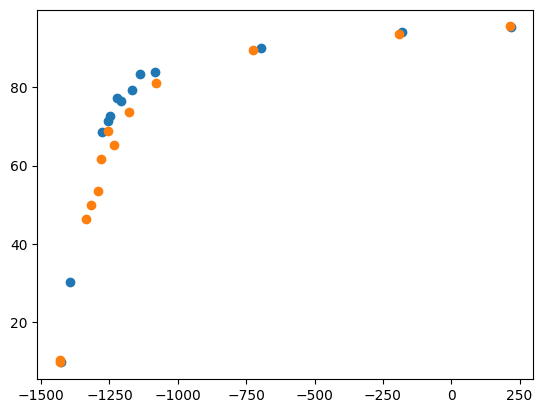

In [10]:
import matplotlib.pylab as plt
%matplotlib inline
plt.scatter(mis, accs)
plt.scatter(mis2, accs2)

In [19]:
def run_trained(mi_coef, k):
    hidden = 28*28

    enc = torch.nn.Sequential(SparseLinearLayer(28*28, hidden, k*k)).to(device)

    w0 = enc[0].weight * 1.0
    b0 = enc[0].bias * 1.0
    dec = torch.nn.Linear(hidden, 28*28).to(device)
    head = torch.nn.Linear(hidden, 10).to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(list(enc.parameters())+ list(dec.parameters())+list(head.parameters()), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Обучение
    for epoch in range(epochs*2):
        tq = tqdm.tqdm(train_loader)
        for b_id, (x, y) in enumerate(tq):
            if epoch < epochs//2:
                enc[0].tau = torch.linspace(1.0, 0.2, epochs*len(train_loader))[epoch*(len(train_loader))+b_id]
            else:
                enc[0].tau = 0

            x, y = x.to(device), y.to(device)
            x = x.flatten(1)
            h = enc(x)
            loss = myent(h)*mi_coef
            h = torch.sigmoid(h)
            
            outputs = dec(h)
            loss += criterion(head(h), y)

            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.set_description(str(loss.item()))

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        if epoch == epochs//2-1:
            enc[0].mask_logits.requires_grad_(False)
            enc[0].weight.data *= 0.0
            enc[0].weight.data += w0.detach()
            enc[0].bias.data *= 0.0

        if epoch in [2*epochs//2-1, 2*epochs-1]:
            mi_ = 0.0
            rec = 0.0
            # Тестирование
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    h = enc(images.flatten(1))
                    mi_ += myent(h)
                    h = torch.sigmoid(h)
                    outputs =  head(h)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    outputs = dec(h)

                    rec += ((outputs-images.flatten(1))**2).mean().item()

            print(f"Accuracy on test set: {100 * correct / total:.2f}%")
            print ('rec', rec/len(train_loader))
            print ('mi:', mi_.item())

    return enc, 100 * correct / total, rec/len(train_loader), mi_.item()


In [35]:
run_trained(.5, 3)

1.7518863677978516: 100%|████████████████████| 938/938 [00:07<00:00, 133.01it/s]


Epoch [1/10], Loss: 1.7519


1.6363179683685303: 100%|████████████████████| 938/938 [00:07<00:00, 130.56it/s]


Epoch [2/10], Loss: 1.6363


1.2547703981399536: 100%|████████████████████| 938/938 [00:07<00:00, 130.84it/s]


Epoch [3/10], Loss: 1.2548


1.3200418949127197: 100%|████████████████████| 938/938 [00:07<00:00, 132.19it/s]


Epoch [4/10], Loss: 1.3200


1.094459056854248: 100%|█████████████████████| 938/938 [00:06<00:00, 135.07it/s]


Epoch [5/10], Loss: 1.0945


0.006850987672805786: 100%|██████████████████| 938/938 [00:07<00:00, 133.01it/s]


Epoch [6/10], Loss: 0.0069


-1.2478524446487427: 100%|███████████████████| 938/938 [00:07<00:00, 133.58it/s]


Epoch [7/10], Loss: -1.2479


-1.7996371984481812: 100%|███████████████████| 938/938 [00:06<00:00, 134.67it/s]


Epoch [8/10], Loss: -1.7996


-2.1610379219055176: 100%|███████████████████| 938/938 [00:06<00:00, 134.16it/s]


Epoch [9/10], Loss: -2.1610


-2.626047372817993: 100%|████████████████████| 938/938 [00:06<00:00, 136.46it/s]


Epoch [10/10], Loss: -2.6260
Accuracy on test set: 68.58%
rec 0.180944148792641
mi: -1179.3319091796875


-2.340606689453125: 100%|████████████████████| 938/938 [00:06<00:00, 134.79it/s]


Epoch [11/10], Loss: -2.3406


-2.376620292663574: 100%|████████████████████| 938/938 [00:06<00:00, 135.92it/s]


Epoch [12/10], Loss: -2.3766


-2.391117811203003: 100%|████████████████████| 938/938 [00:06<00:00, 136.33it/s]


Epoch [13/10], Loss: -2.3911


-2.706721782684326: 100%|████████████████████| 938/938 [00:06<00:00, 137.00it/s]


Epoch [14/10], Loss: -2.7067


-2.638902425765991: 100%|████████████████████| 938/938 [00:06<00:00, 138.06it/s]


Epoch [15/10], Loss: -2.6389


-2.795542001724243: 100%|████████████████████| 938/938 [00:06<00:00, 138.02it/s]


Epoch [16/10], Loss: -2.7955


-2.81400203704834: 100%|█████████████████████| 938/938 [00:06<00:00, 136.30it/s]


Epoch [17/10], Loss: -2.8140


-2.901498794555664: 100%|████████████████████| 938/938 [00:06<00:00, 135.86it/s]


Epoch [18/10], Loss: -2.9015


-2.767817735671997: 100%|████████████████████| 938/938 [00:06<00:00, 136.90it/s]


Epoch [19/10], Loss: -2.7678


-3.0169060230255127: 100%|███████████████████| 938/938 [00:06<00:00, 138.28it/s]


Epoch [20/10], Loss: -3.0169
Accuracy on test set: 68.35%
rec 0.18045244669355054
mi: -1273.900634765625


(Sequential(
   (0): SparseLinearLayer()
 ),
 68.35,
 0.18045244669355054,
 -1273.900634765625)

In [32]:
weight_sum = abs(enc[0].weight.sum(1))
neuron_weights = torch.argsort(weight_sum).cpu().detach().numpy().tolist()
weight_sum[neuron_weights[-1]]/weight_sum[neuron_weights[400]]

tensor(4.8947, device='cuda:0', grad_fn=<DivBackward0>)

In [39]:
accs, mis

([95.42, 93.88, 85.0, 79.3, 70.34, 69.89, 10.35, 9.89],
 [217.56971740722656,
  -167.44033813476562,
  -1009.5508422851562,
  -1180.653076171875,
  -1251.819580078125,
  -1263.0340576171875,
  -1431.5048828125,
  -1428.5792236328125])

np.float64(5.640393233752549)

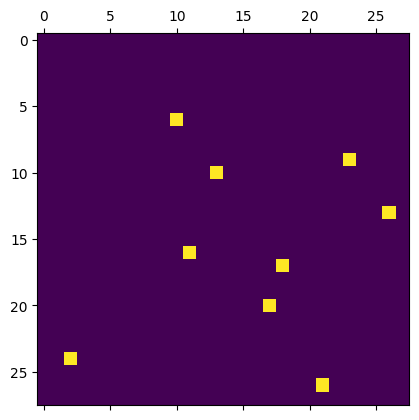

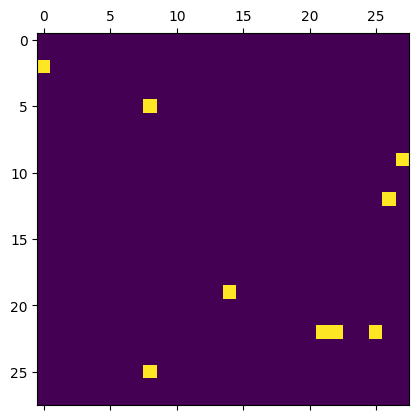

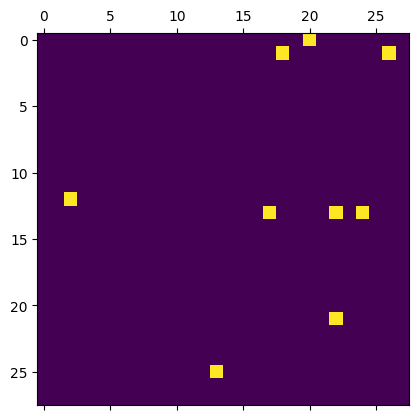

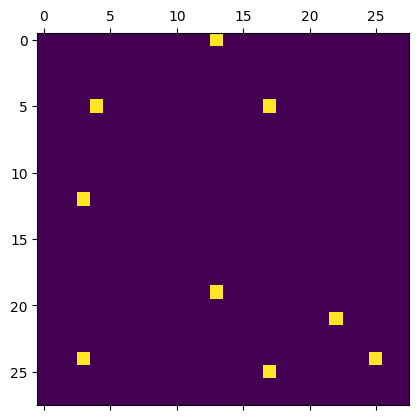

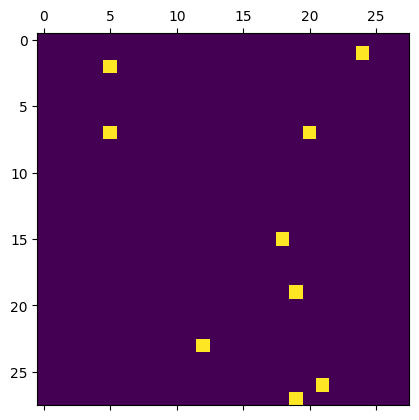

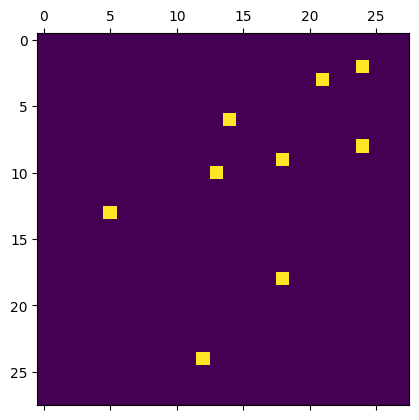

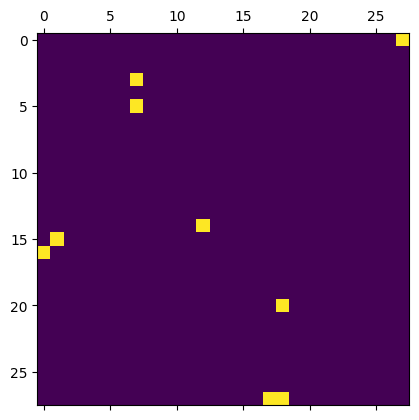

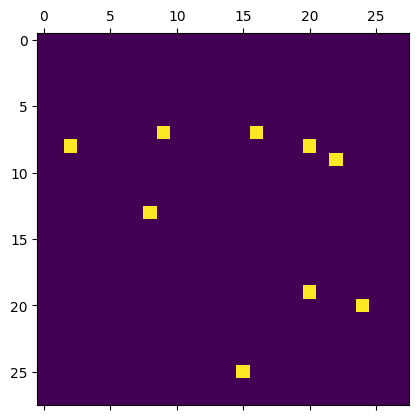

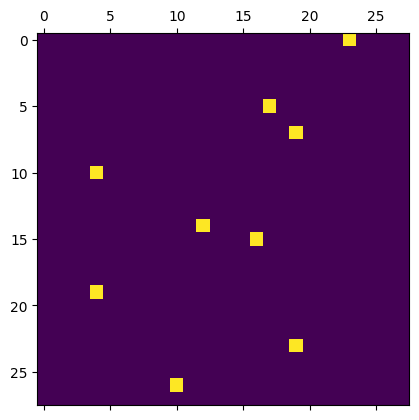

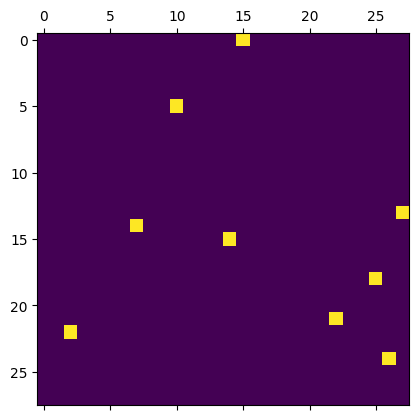

In [36]:
from scipy.spatial.distance import cdist
mask = enc[0].sample_mask().cpu().detach()
d = []
for i in neuron_weights[-10:]:
    coords = np.vstack(np.where(abs(mask[i].view(28, 28))>0))
    dists = cdist(coords.T, coords.T)
    neighb = dists.argsort(axis=1)[:,1]
    d.append(dists[range(len(dists)), neighb].mean())

    plt.matshow(abs(mask[i].view(28, 28)))
    
np.mean(d)

In [34]:
mis

[217.56971740722656,
 -167.44033813476562,
 -1009.5508422851562,
 -1180.653076171875,
 -1251.819580078125,
 -1263.0340576171875,
 -1431.5048828125,
 -1428.5792236328125]

In [108]:
enc = run(10.0, 3)

18484.326171875: 100%|███████████████████████| 938/938 [00:05<00:00, 157.29it/s]


Epoch [1/10], Loss: 18484.3262


18070.810546875: 100%|███████████████████████| 938/938 [00:05<00:00, 174.65it/s]


Epoch [2/10], Loss: 18070.8105


17361.3828125: 100%|█████████████████████████| 938/938 [00:05<00:00, 169.33it/s]


Epoch [3/10], Loss: 17361.3828


17135.65625: 100%|███████████████████████████| 938/938 [00:05<00:00, 167.18it/s]


Epoch [4/10], Loss: 17135.6562


16110.53515625: 100%|████████████████████████| 938/938 [00:06<00:00, 152.81it/s]


Epoch [5/10], Loss: 16110.5352


12653.5625: 100%|████████████████████████████| 938/938 [00:06<00:00, 149.78it/s]


Epoch [6/10], Loss: 12653.5625


11290.7431640625: 100%|██████████████████████| 938/938 [00:05<00:00, 158.69it/s]


Epoch [7/10], Loss: 11290.7432


10120.7568359375: 100%|██████████████████████| 938/938 [00:06<00:00, 155.96it/s]


Epoch [8/10], Loss: 10120.7568


9261.50390625: 100%|█████████████████████████| 938/938 [00:05<00:00, 159.76it/s]


Epoch [9/10], Loss: 9261.5039


8963.1865234375: 100%|███████████████████████| 938/938 [00:06<00:00, 154.95it/s]


Epoch [10/10], Loss: 8963.1865
Accuracy on test set: 92.13%
rec 0.01602402111011019
mi: 144187.96875


8701.0986328125: 100%|███████████████████████| 938/938 [00:06<00:00, 155.70it/s]


Epoch [11/10], Loss: 8701.0986


8441.990234375: 100%|████████████████████████| 938/938 [00:05<00:00, 159.87it/s]


Epoch [12/10], Loss: 8441.9902


8578.05859375: 100%|█████████████████████████| 938/938 [00:06<00:00, 152.38it/s]


Epoch [13/10], Loss: 8578.0586


8407.494140625: 100%|████████████████████████| 938/938 [00:05<00:00, 160.64it/s]


Epoch [14/10], Loss: 8407.4941


8040.69970703125: 100%|██████████████████████| 938/938 [00:06<00:00, 154.30it/s]


Epoch [15/10], Loss: 8040.6997


7998.40966796875: 100%|██████████████████████| 938/938 [00:06<00:00, 153.02it/s]


Epoch [16/10], Loss: 7998.4097


7969.8525390625: 100%|███████████████████████| 938/938 [00:06<00:00, 150.43it/s]


Epoch [17/10], Loss: 7969.8525


7771.19384765625: 100%|██████████████████████| 938/938 [00:05<00:00, 165.07it/s]


Epoch [18/10], Loss: 7771.1938


7732.86083984375: 100%|██████████████████████| 938/938 [00:06<00:00, 155.85it/s]


Epoch [19/10], Loss: 7732.8608


7912.7568359375: 100%|███████████████████████| 938/938 [00:06<00:00, 153.34it/s]


Epoch [20/10], Loss: 7912.7568
Accuracy on test set: 93.64%
rec 0.01728744152734783
mi: 125312.1015625


In [143]:
weight_sum = abs(enc[0].weight.sum(1))
neuron_weights = torch.argsort(weight_sum).cpu().detach().numpy().tolist()
weight_sum[neuron_weights[-1]]/weight_sum[neuron_weights[400]]

tensor(4.6735, device='cuda:0', grad_fn=<DivBackward0>)

In [109]:
weight_sum = abs(enc[0].weight.sum(1))
neuron_weights = torch.argsort(weight_sum).cpu().detach().numpy().tolist()
weight_sum[neuron_weights[-1]]/weight_sum[neuron_weights[400]]

tensor(4.8670, device='cuda:0', grad_fn=<DivBackward0>)

In [144]:
from scipy.spatial.distance import cdist
mask = enc[0].sample_mask().cpu().detach()
d = []
for i in neuron_weights[400:]:
    coords = np.vstack(np.where(abs(mask[i].view(28, 28))>0))
    dists = cdist(coords.T, coords.T)
    neighb = dists.argsort(axis=1)[:,1]
    d.append(dists[range(len(dists)), neighb].mean())

    #plt.matshow(abs(mask[i].view(28, 28)))
    
np.mean(d)

np.float64(5.570520928585251)

np.float64(1.0)

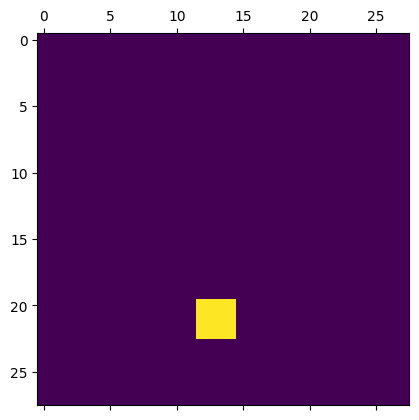

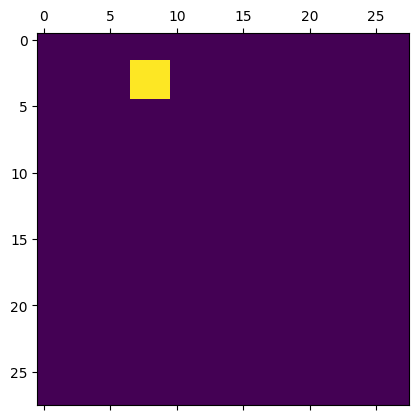

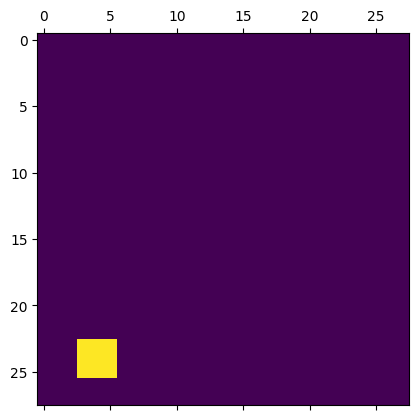

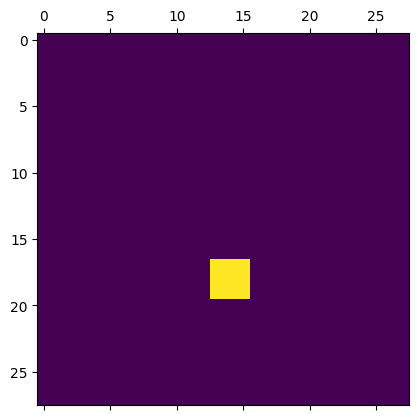

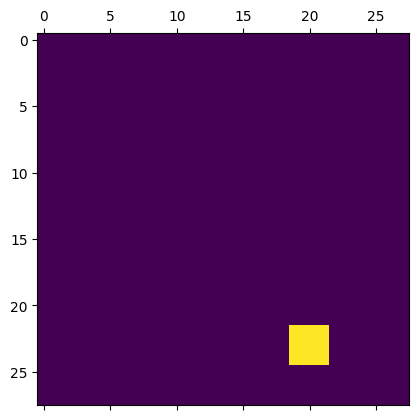

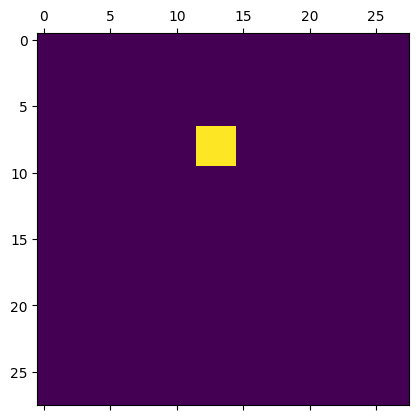

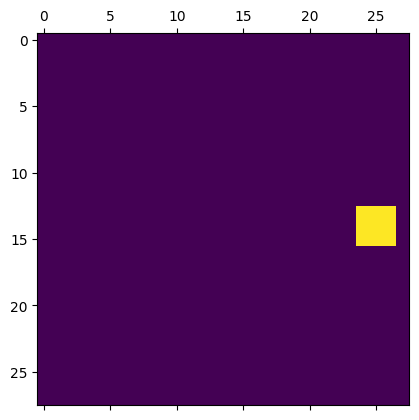

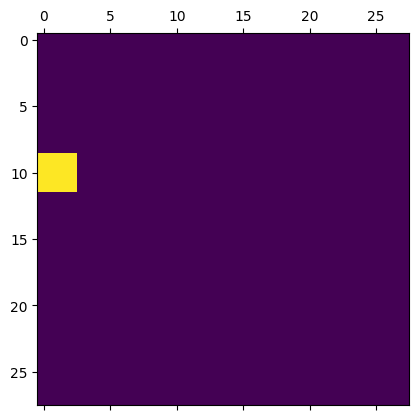

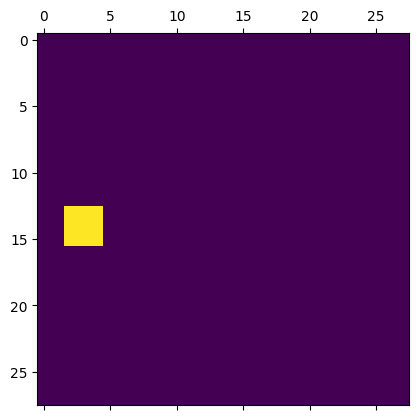

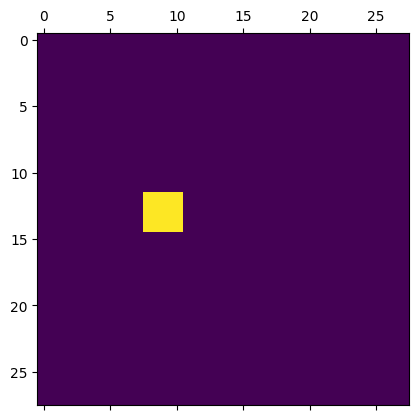

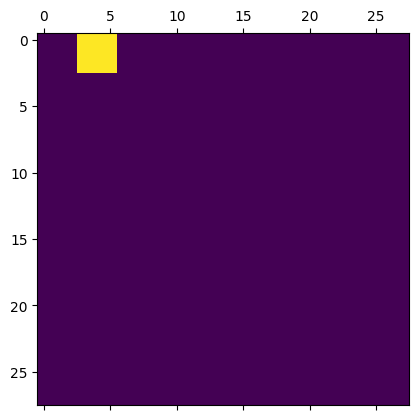

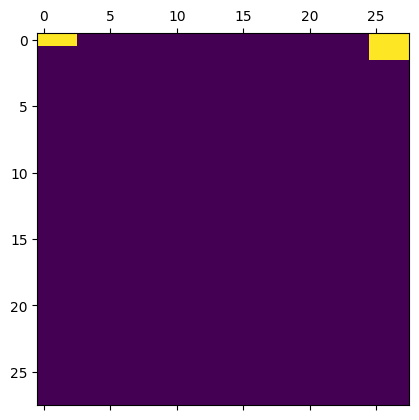

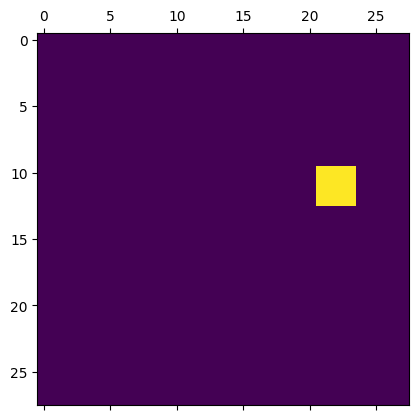

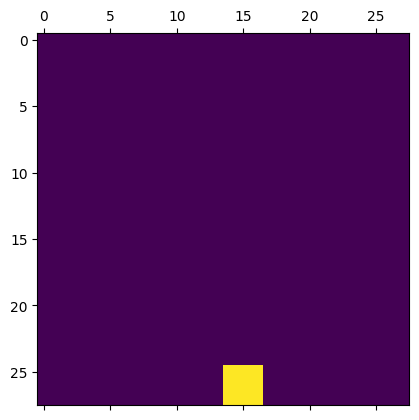

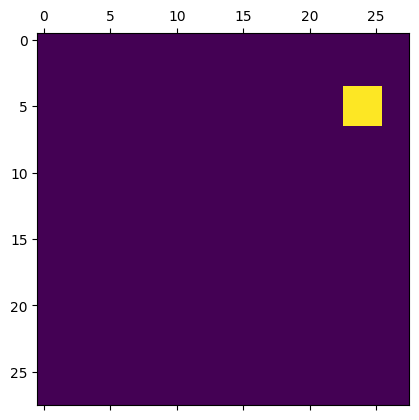

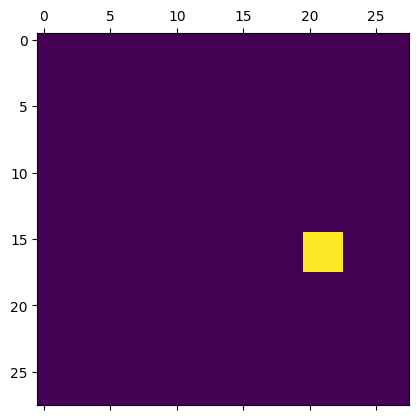

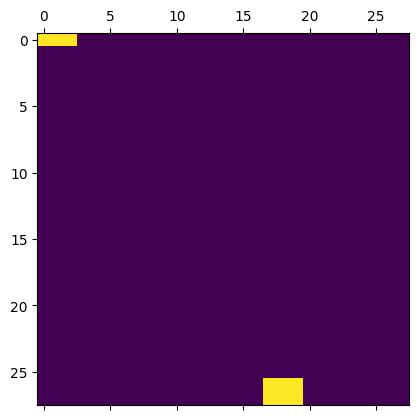

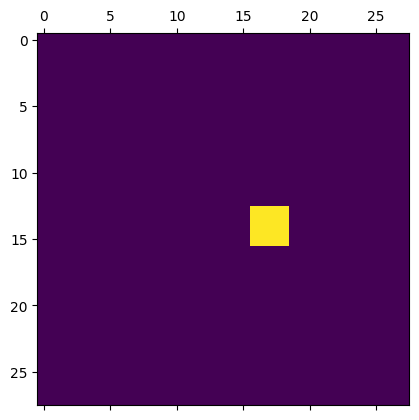

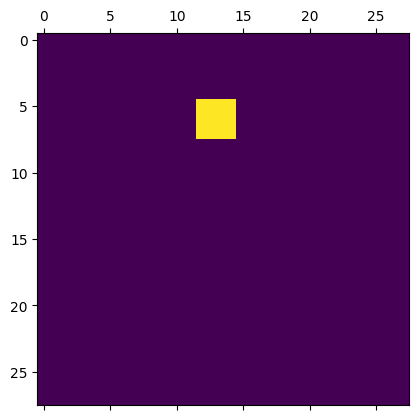

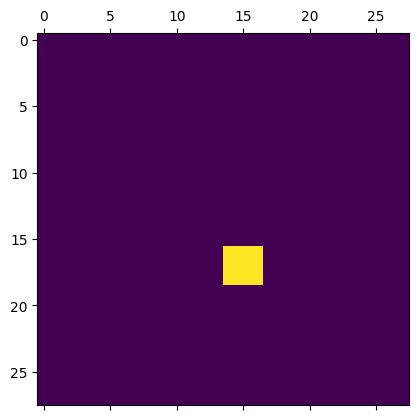

In [122]:
from scipy.spatial.distance import cdist
mask = enc[0].sample_mask().cpu().detach()
d = []
for i in neuron_weights[-20:]:
    coords = np.vstack(np.where(abs(mask[i].view(28, 28))>0))
    dists = cdist(coords.T, coords.T)
    neighb = dists.argsort(axis=1)[:,1]
    d.append(dists[range(len(dists)), neighb].mean())

    plt.matshow(abs(mask[i].view(28, 28)))
    
np.mean(d)

np.float64(5.597679009724728)

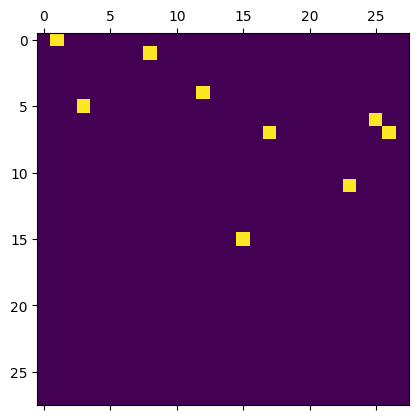

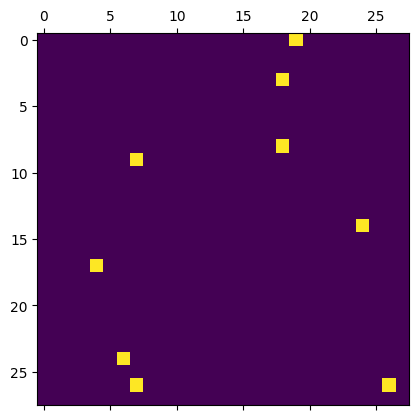

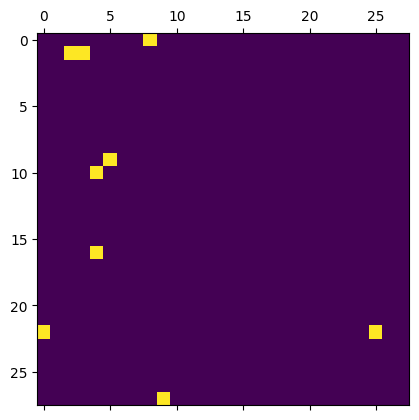

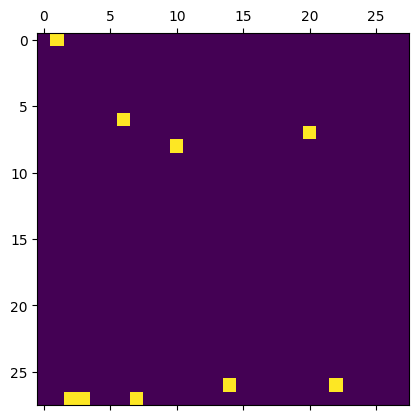

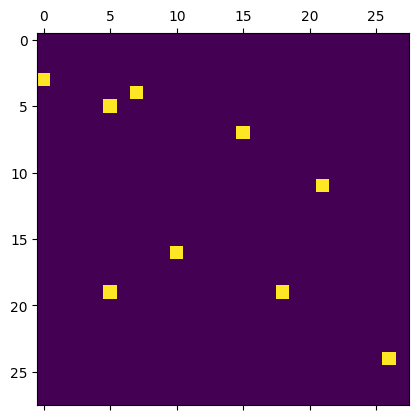

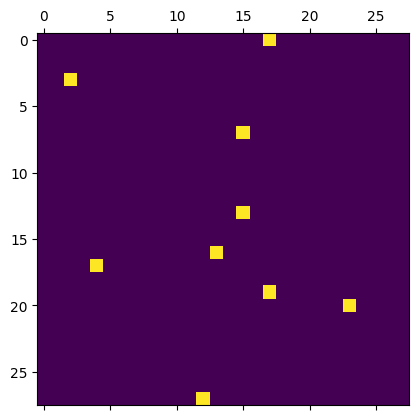

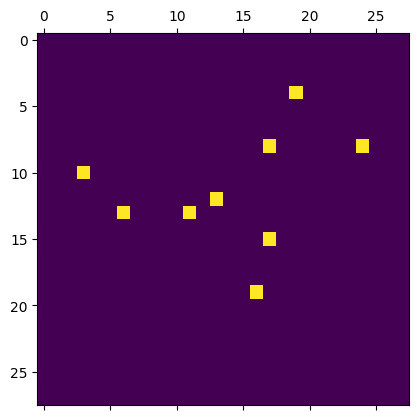

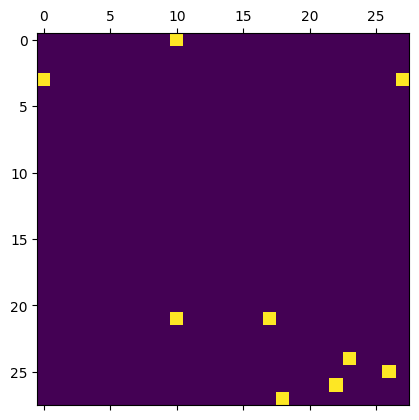

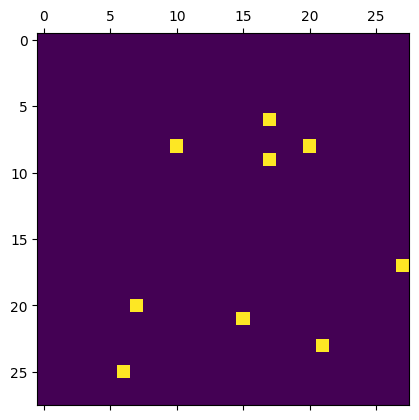

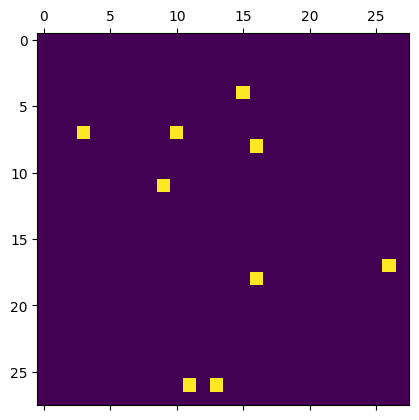

In [145]:
from scipy.spatial.distance import cdist
mask = enc[0].sample_mask().cpu().detach()
d = []
for i in neuron_weights[-10:]:
    coords = np.vstack(np.where(abs(mask[i].view(28, 28))>0))
    dists = cdist(coords.T, coords.T)
    neighb = dists.argsort(axis=1)[:,1]
    d.append(dists[range(len(dists)), neighb].mean())

    plt.matshow(abs(mask[i].view(28, 28)))
    
np.mean(d)